In [1]:
import re

# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from imblearn.over_sampling import RandomOverSampler

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

/Users/jerry/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Reading datasets
pos_file_path = 'data/Processed/pos.csv'
neg_file_path = 'data/Processed/neg.csv'

pos_df = pd.read_csv(pos_file_path, index_col=0)
pos_df = pos_df.drop(columns=['FileName'])

neg_df = pd.read_csv(neg_file_path, index_col=0)
neg_df = neg_df.drop(columns=['FileName'])

# Bring all positive rating values down to range of 5-8 (to ensure continuous range of ratings)
pos_df['rating'] = pos_df['rating'] - 2

# Merging data into one dataset
data = pd.concat([pos_df, neg_df], ignore_index=True)

In [3]:
data.head()

,Content,rating
0,"I just watched ""return from lonesome dove"" and...",7
1,This movie looked like a classic in the cheesy...,6
2,Jay Chou plays an orphan raised in a kung fu s...,6
3,"Ooverall, the movie was fairly good, a good ac...",5
4,"This movie is fun to watch. If you liked ""Dave...",6


# Deep Learning Model Evaluaiton

## Model 1: Bidrectional Encoder Representaions 

In [4]:
MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


## Data Visualisation

In [10]:
token_lens = []

# Iterate through the content slide
for txt in data.Content:
    tokens = tokenizer.encode(txt, max_length=1024)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

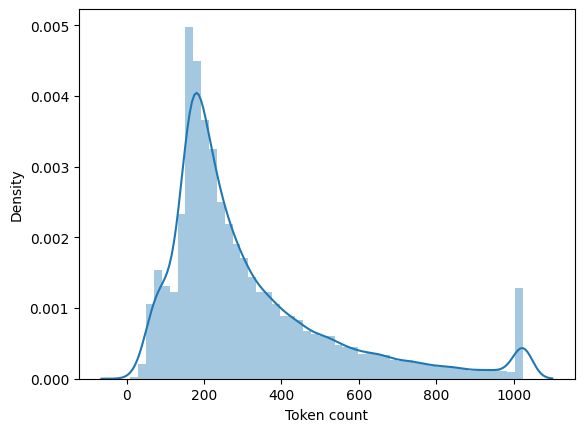

In [11]:
sns.distplot(token_lens)
plt.xlabel('Token count')

In [13]:
MAX_LEN = 800

### Scenario 1: Using Random Oversampler to balance classes

In [16]:
data['rating'].value_counts(ascending=True)

rating
2     4586
7     4607
5     4803
3     4961
4     5331
6     5859
8     9731
1    10122
Name: count, dtype: int64

In [17]:
from imblearn.over_sampling import RandomOverSampler

In [18]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(data['Content']).reshape(-1, 1), np.array(data['rating']).reshape(-1, 1))

#Get Oversampled training data
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['Content', 'rating'])

In [20]:
train_os['rating'].value_counts(ascending=True)

rating
7    10122
6    10122
5    10122
8    10122
4    10122
1    10122
3    10122
2    10122
Name: count, dtype: int64

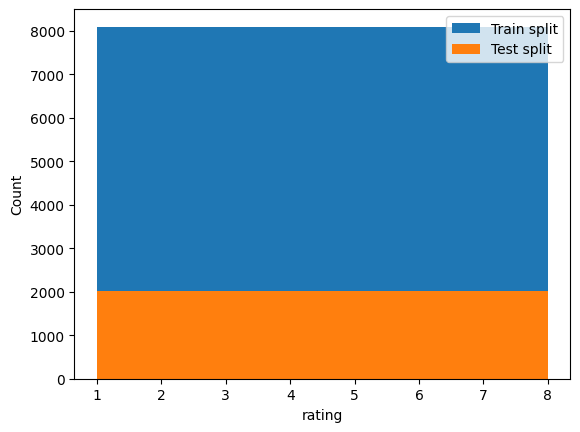

In [21]:
X = train_os['Content']
y = train_os['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200, stratify=y)
train_split = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], ignore_index=True, axis=1)
train_split = train_split.rename(columns={0: 'Content', 1: 'rating'}) 

test_split = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], ignore_index=True, axis=1)
test_split = test_split.rename(columns={0: 'Content', 1: 'rating'}) 

plt.hist(train_split['rating'], bins=8)
plt.hist(test_split['rating'], bins=8)
plt.xlabel('rating')
plt.ylabel('Count')
plt.legend(['Train split', 'Test split'])

Check shape of training and test data

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(64780,)
(64780,)
(16196,)
(16196,)


In [18]:
# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 4
LEARNING_RATE = 1e-05

In [ ]:
class CustomDataset(Dataset):
    ''' Custom dataset class defined to create '''

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.Content = dataframe.Content
        self.targets = self.data.list
        self.max_len = max_len

    # __len__ and __getitem__ methods to create map-style dataset to be interfaced by torch DataLoader method
    def __len__(self):
        return len(self.Content)

    def __getitem__(self, index):
        # Data preprocessing code to convert to lower-cased, remove trailing whitespace, html tags and urls
        Content = str(self.Content[index]).lower()
        Content = re.sub(r'<[^>]+>', '', Content)  
        Content = re.sub(r'https://\S+|www\.\S+', '', Content)
        Content = " ".join(Content.split())

        # Tokenisation of text
        inputs = self.tokenizer.encode_plus(
            Content,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

Create Data Loader

## Scenario 2: No Oversampling 